In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
import scipy.sparse as sparse
import pandas as pd
import time
%matplotlib inline

# 0. Helper Functions

In [3]:
def kmeans(X, k, iteration=-1):
    ######INIT######
    #init C, C_members randomly
    (N, d) = X.shape
    C = np.random.randint(0,k,[N,1])  # used to update classes fast
    C_members = a = [set() for i in range(k)]  # used to compute centers fast
    C_centers = np.ones([k, d])  # used to store center values    

    for i in range(N):  # 
        C_members[C[i,0]].add(i)
    ######INIT######
        
    flag = True
    counter = 0
    while flag:        
        C_centers_prev = C_centers.copy()
        for i in range(k):  # compute C_centers            
            indices = [j for j in C_members[i]]
            C_centers[i] = np.mean(X[indices,:],0)

        for i in range(N):  # update C, C_members
            C_old = C[i,0]
            C_members[C_old].remove(i)

            diff = C_centers - X[i,:]
            C_new = np.argmin(np.sum(diff**2, 1))

            C_members[C_new].add(i)
            C[i,0] = C_new

        counter += 1
        #print(np.linalg.norm(C_centers - C_centers_prev))
        if np.linalg.norm(C_centers - C_centers_prev) < 0.01 or (iteration == counter):
            flag = False
        
    return (C, C_centers, C_members, counter)                    

In [4]:
def cluster_plot(X, C_centers):    
    colors = ['#e47993','#7bb227','#4e0f91','#98332e','#5fabb2','#458186']

    f = plt.figure()
    ax = f.add_subplot(111)
    ax.set_title('K-means')
    
    for i in range(N):
        ax.plot(X[i,0],X[i,1],'.',color=colors[C[i,0]],lw=2)

    for i in range(k):
        ax.plot(C_centers[i,0], C_centers[i,1],'.',color=colors[i],lw=2, markersize=20)

# 1. Read JSON in to variable
- Provide the path to main directory containing all songs

In [5]:
lastfmdir = '/Users/oeken/Downloads/lastfm_subset/'
jsons = []

for root, dirs, files in os.walk(lastfmdir):
    jsons += [root + '/' + s for s in files]
    
print('How many songs?',len(jsons))

How many songs? 9330


In [6]:
%%time
# Read the jsons to the variable data
song_ids = {}
songs = []
counter = 0
for jsondir in jsons:
    with open(jsondir,'r') as f:
        jsonstr = f.read()
        jsondict = json.loads(jsonstr)
        songs.append(jsondict)
        song_ids[jsondict['track_id']] = counter
        counter += 1

print(len(songs))

9330
CPU times: user 2.12 s, sys: 733 ms, total: 2.85 s
Wall time: 5.09 s


# 3. Preprocess Songs

1. We want to discard **dangling songs** from our data. A dangling song is the song that there is no json file associated with it in the *Last.fm* dataset.

2. Additionally, we want to eliminate similar **songs that are not that similar** (determined by thresholding with $\theta$)

3. Furthermore, we want to eliminate **disjoint songs** that are:
    - Does not point any other song (means similar list is empty)
    - Not pointed by any other song.

### 3.1 Eliminate Dangling + Dissimilar ( $\theta$ ) Songs
- Here set the parameter $0 \leq \theta \leq 1$
- Note: We are removing songs from *'similar'* field of songs

In [7]:
theta = 0.1
discarded_songs = 0
for song in songs:
    distilled_similars = []
    for similartrack in song['similars']:        
        tr = similartrack[0]
        sim = similartrack[1]        
        if tr in song_ids and sim >= theta:  
            distilled_similars.append(similartrack)                    
        else:
            discarded_songs += 1
    song['similars'] = distilled_similars

print('How many songs are discarded?',discarded_songs)

How many songs are discarded? 609507


### 3.2 Find Out Referral Set

In [8]:
referral = set()
for song in songs:
    for similartrack in song['similars']:        
        tr = similartrack[0]
        referral.add(tr)        

In [9]:
print('How many songs we have? %d' %(len(songs)))

How many songs we have? 9330


In [10]:
print('How many songs are being reffered? %d' %(len(referral)))

How many songs are being reffered? 1257


### 3.3 Eliminate Disjoint Songs

In [11]:
songs_distilled = []
song_ids_distilled = {}
counter = 0
dc_counter = 0
for song in songs:    
    if len(song['similars']) != 0 or song['track_id'] in referral:
        songs_distilled.append(song)            
        song_ids_distilled[song['track_id']] = counter
        counter += 1
    else:
        dc_counter += 1

In [12]:
print('How many songs are discarded? %d' % dc_counter)

How many songs are discarded? 7270


In [13]:
print('How many songs are left in dataset after preprocessing? %d' % len(songs_distilled))

How many songs are left in dataset after preprocessing? 2060


In [14]:
# Update variables and delete auxiliary variables
songs = songs_distilled
song_ids = song_ids_distilled
N = len(songs)

In [15]:
del songs_distilled
del song_ids_distilled

# 4. Preprocess Tags
- Eliminate Weak  ($\gamma$) Tags and Assign Tag IDs
- Here set the parameter $0 \leq \gamma \leq 100$

In [16]:
tag2id = {}  # Mapping: tag name --> Tag ID
id2tag = {}  # Mapping: tag ID --> tag name

gamma = 10
discarded_tags = 0
INDEX_TAG = 0

for song in songs:
    distilled_tags = []
    for tag in song['tags']:                
        if int(tag[1]) >= gamma:            
            distilled_tags.append(tag)
            if not tag[0] in tag2id:  
                tag2id[tag[0]] = INDEX_TAG
                id2tag[INDEX_TAG] = tag[0]
                INDEX_TAG += 1
        else:
            discarded_tags += 1    
    song['tags'] = distilled_tags

print('How many tags are discarded?',discarded_tags)

How many tags are discarded? 31776


In [17]:
N_tag = len(tag2id)

In [18]:
songs[0]['tags']

[['Bay Area', '100'],
 ['hieroglyiphics', '100'],
 ['classic', '50'],
 ['Hip-Hop', '50'],
 ['stream', '50'],
 ['OG', '50'],
 ['1979-2006: A Hip-Hop Odyssey - 800 Tracks In A 48 Minute Mix', '50'],
 ['heiroglyphics', '50'],
 ['oaksterdamn', '50']]

# 5. Form Song ID - Tag ID Dictionaries

In [19]:
song2tag = {}  # mapping: song ID --> tag ID
tag2song = {}  # mapping: tag ID --> song ID

for song in songs:
    track = song['track_id']
    song_id = song_ids[track]
    if not song_id in song2tag:
        song2tag[song_id] = set()

    for tag in song['tags']:
        tagid = tag2id[tag[0]]
        song2tag[song_id].add(tagid)
        if tagid not in tag2song:
            tag2song[tagid] = set()            
        tag2song[tagid].add(song_id)        

**Example:** *Tag IDs of the first song*

In [20]:
print(song2tag[0])
[id2tag[i] for i in song2tag[0]]

{0, 1, 2, 3, 4, 5, 6, 7, 8}


['Bay Area',
 'hieroglyiphics',
 'classic',
 'Hip-Hop',
 'stream',
 'OG',
 '1979-2006: A Hip-Hop Odyssey - 800 Tracks In A 48 Minute Mix',
 'heiroglyphics',
 'oaksterdamn']

**Example:** *Songs having the first tag*

In [21]:
print(id2tag[0])
print(tag2song[0])

[[songs[i]['artist'], songs[i]['title']] for i in tag2song[0]]

Bay Area
{0, 75}


[['Casual', "I Didn't Mean To"], ['Casual', 'OAKtown']]

# 6. Form $W$ (Weighted Adjacency Matrix)

In [22]:
%%time
pairs = {}
for song in songs: 
    refsong_id = song_ids[song['track_id']]
    for simsong in song['similars']:
        simsong_id = song_ids[simsong[0]]
        one = str(refsong_id) + '+' + str(simsong_id)
        two = str(simsong_id) + '+' + str(refsong_id)
        if two in pairs:
            pairs[two] = max(pairs[two], simsong[1])
        else:
            pairs[one] = simsong[1]
            

row_ind = []
col_ind = []
values = []
            
for pair in pairs.keys():
    arr = pair.split('+')    
    one = int(arr[0])
    two = int(arr[1])
    
    col_ind.append(one)
    row_ind.append(two)
    values.append(pairs[pair])
    
    col_ind.append(two)
    row_ind.append(one)
    values.append(pairs[pair])
    

CPU times: user 20.7 ms, sys: 1.19 ms, total: 21.9 ms
Wall time: 21.2 ms


In [28]:
W = sparse.csc_matrix((values, (row_ind, col_ind)), shape=(N,N), dtype=np.float64)
W.sum(0)
print('Is it symmetric?',(W.T.toarray() == W.toarray()).all())

Is it symmetric? True


In [29]:
# Test if there is a disjoint song in the set
(W.sum(0) == 0).any()

False

In [30]:
%%time
D = sparse.csc_matrix(np.diag(W.sum(0).tolist()[0]))

CPU times: user 71.6 ms, sys: 8.32 ms, total: 79.9 ms
Wall time: 82.2 ms


In [31]:
%time
L = D - W

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


In [32]:
((L.sum(0) == 0) - 1).sum()

-465

In [33]:
np.linalg.matrix_rank(L.toarray())

1611

In [34]:
%%time
k = 5
eigvals, eigvecs = sparse.linalg.eigsh(L, k=k, which='LM', sigma=0.000000000000001)

CPU times: user 243 ms, sys: 8.25 ms, total: 251 ms
Wall time: 149 ms


In [35]:
eigvals

array([  5.63104291e-17,   5.63104291e-17,   5.95757909e-17,
         6.05805176e-17,   1.56230501e-16])

In [36]:
eigvecs

array([[  4.14023553e-18,  -3.24500672e-18,  -5.47816256e-18,
          1.08191679e-17,   1.61502078e-18],
       [  6.52028538e-15,   5.55111512e-16,   3.83859611e-14,
          1.38675049e-01,   1.10551698e-16],
       [ -5.85635773e-18,  -4.48823312e-18,   1.13998422e-18,
          4.86306960e-18,  -1.49029766e-18],
       ..., 
       [ -9.31982308e-19,  -3.04196006e-18,   8.23168582e-21,
          3.64097995e-18,   6.29283519e-19],
       [  1.18270072e-01,   7.79993611e-02,   3.17435996e-15,
         -5.98459604e-15,  -1.38835082e-16],
       [ -2.23891105e-16,  -1.15016229e-17,   2.73351710e-16,
         -1.75346645e-17,  -6.31171936e-17]])

In [37]:
(C, C_centers, C_members, c) = kmeans(eigvecs, k)

In [38]:
c

5

In [39]:
(C == 6).sum()

0

In [40]:
pd.DataFrame(C.T)

,0,1,2,3,4,5,6,7,8,9,...,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059
0,1,4,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [41]:
type(C_members[0])

set

In [42]:
#tagx = np.arange(0, N_tag)
#tagy = np.zeros([k, N_tag])
tagcounts = [[] for i in range(k)]
counter = 0
for curr_members in C_members:    
    for curr_song_id in curr_members:
        for curr_tag in song2tag[curr_song_id]:
            tagcounts[counter].append(id2tag[curr_tag])
            #tagy[counter,curr_tag] += 1
    counter += 1


In [47]:
clustersongcounts = []
for members in C_members:
    clustersongcounts.append(len(members))
    
clustertagcounts = []
for i in range(k):
    clustertagcounts.append(len(tagcounts[i]))

[94, 12276, 39, 58, 419]

**Cluster Song Counts**

In [52]:
pd.DataFrame(clustersongcounts).T

,0,1,2,3,4
0,10,1969,12,17,52


**Cluster Tag Counts**

In [53]:
pd.DataFrame(clustertagcounts).T

,0,1,2,3,4
0,94,12276,39,58,419


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 <a list of 32 Text xticklabel objects>)

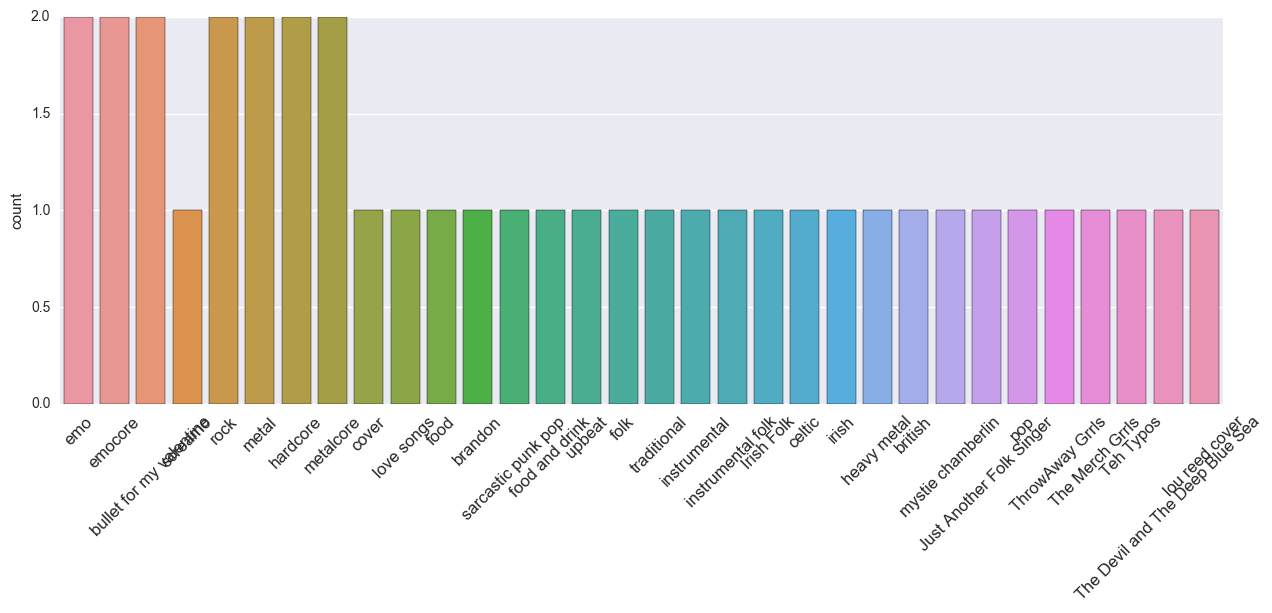

In [80]:
whichcluster = 2
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(111)    
sns.countplot(tagcounts[whichcluster], ax=ax)
plt.xticks(rotation=45, fontsize=12)